<h1 style="color: #0071b9; text-align: center;">Master SID - Raisonnement dans l'incertain</h1>
<h2 style="color: #0071b9; text-align: center;">TP n°3 - Apprentissage de structure</h2>
<h2 style="color: #0071b9; text-align: center;">Nouvelle application à la reconnaissance de chiffres</h2>
<br/><br/>

Binome :

* Rose-Myrvelie MASSILLON
* Akim SAADI

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Préparation / visualisation</h1>

Dans ce TP, vous allez reprendre le problème de reconnaissance de chiffres du TP n°2 mais, à la différence de ce dernier, vous allez apprendre la structure du réseau bayésien plutôt que d'utiliser un réseau de Bayes naïf.

Vous trouverez ci-dessous les fonctions qui permettaient de lire les bases de données et d'afficher des images de la base.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyAgrum as gum
import pyAgrum.lib.notebook as gnb


NB_NIVEAUX_GRIS = 16  # encodage des images en 16 niveaux de gris
LARGEUR_IMAGE = 16    # les images ont 16 pixels en largeur
HAUTEUR_IMAGE = 16    # et 16 pixels en hauteur
NB_PIXELS = LARGEUR_IMAGE * HAUTEUR_IMAGE  # nombre de pixels par image


def read_file(filename):
    """
    Lit un fichier USPS et renvoie un tableau T de listes d'images.
    """
    # lecture de l'en-tête
    infile = open(filename, "r")
    nb_classes, nb_features = [int(x) for x in infile.readline().split()]

    # on teste que les images ont bien NB_PIXELS pixels
    if nb_features != NB_PIXELS:
        raise ValueError("Les images doivent être de 16x16 pixels")

    # creation de la structure de données pour sauver les images :
    # c'est un tableau de listes d'images (1 liste par classe)
    data = np.empty(10, dtype=object)
    for i in range(10):
        data[i] = []

    # lecture des images du fichier et insertion dans la liste correspondant
    # à leur classe
    for ligne in infile:
        champs = ligne.split()
        if len(champs) == nb_features + 1:
            classe = int(champs.pop(0))
            champs_reel = [float(x) for x in champs]
            pixel_max = max(champs_reel)
            champ_discret = [int(x / pixel_max * (NB_NIVEAUX_GRIS-1) + 0.5) for x in champs_reel]
            data[classe].append(champ_discret)

    infile.close()
    return data


def display_image(image):
    """
    Affiche une image dans une fenêtre graphique.
    """
    # on teste que la liste contient bien 256 valeurs
    if len(image) != NB_PIXELS:
        raise ValueError("Les images doivent être de 16x16 pixels")

    # on crée une image pour imshow: chaque pixel est un tableau à 3 valeurs
    # (1 pour chaque canal R,G,B). Ces valeurs sont comprises entre 0 et 1.
    image_normalisee = list(map(lambda x: x / NB_NIVEAUX_GRIS, image))
    img = np.zeros((len(image_normalisee), 3))
    for i in range(3):
        img[:, i] = image_normalisee

    # on indique que toutes les images sont de 16x16 pixels
    img.shape = (LARGEUR_IMAGE, HAUTEUR_IMAGE, 3)

    # affichage de l'image
    plt.imshow(img)
    plt.show()


training_data = read_file("datasets/usps_train.txt")
test_data = read_file("datasets/usps_test.txt")

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 1</h1>

Pour apprendre un réseau bayésien à partir d'une base de données, pyAgrum fournit une classe appelée <code>BNLearner</code>. Celle-ci est capable de lire des datasets à partir de bases de données SQL ou bien de fichiers CSV, mais pas à partir des variables <code>training_data</code> et <code>test_data</code> créées au dessus. Pour pyAgrum, un CSV est un fichier texte dans lequel la première ligne contient les noms des variables et les lignes suivantes contiennent les données. Les colonnes sont séparées par des virgules (",").

Ecrivez une fonction <code>create_CSV</code> qui prend en paramètres un des datasets créés ci-dessus ainsi qu'un nom de fichier et qui crée le fichier CSV du dataset. On rappelle que la structure d'un dataset T (<code>T = training_data</code> ou <code>T = test_data</code>) est la suivante (cf. la section préparation/visualisation du TP n°2) :

* T est un tableau numpy de 10 listes d'images, une liste par valeur de la classe (chiffre).
* T[i] est la liste de toutes les images correspondant à la classe i.
* T[i][j] est la jème image de la classe i. C'est une liste de NB_PIXELS valeurs entières (niveaux de gris compris entre 0 et NB_NIVEAUX_GRIS - 1).

Créez deux fichiers CSV : "datasets/usps_train.csv" pour la base d'apprentissage et "datasets/usps_test.csv" pour la base de tests. Dans le TP n°2, la variable classe s'appelait <code>C</code> et la variable de tout pixel i <code>Xi</code> (par exemple, <code>X42</code> pour le pixel 42).

In [2]:
def create_CSV(dataset,filename) :
    fichier = open("{}.csv".format(filename), "w")
    fichier.write("C,")
    for a in range(NB_PIXELS):
        delimitateur = ","
        if a == NB_PIXELS -1:
            delimitateur=""
        fichier.write("X{}".format(a)+ delimitateur)
    fichier.write('\n')
    for classe in range(len(dataset)) :
            for i, image in enumerate(dataset[classe]) :
                fichier.write(str(classe)+",")
                for pixel in range(NB_PIXELS) :
                    space = ","
                    if i == len(dataset[classe])-1 and pixel == NB_PIXELS-1 :
                        space=""
                    fichier.write(str(dataset[classe][i][pixel])+space)
                fichier.write('\n')
    fichier.close()
    
create_CSV(test_data,"datasets/usps_train")
create_CSV(test_data,"datasets/usps_test")

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 2</h1>

Pour créer un <code>BNLearner</code>, il suffit d'exécuter une instruction <code>learner = gum.BNLearner(nom_fichier_csv)</code>. Créez votre learner et affichez les noms des variables (la méthode <code>names()</code> du learner renvoie justement un tuple avec ces noms). Vérifiez que vous voyez bien un tuple avec les 257 variables (la classe + les 256 variables des pixels).

In [3]:
learner = gum.BNLearner("datasets/usps_train.csv")
print(learner.names())

('C', 'X0', 'X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8', 'X9', 'X10', 'X11', 'X12', 'X13', 'X14', 'X15', 'X16', 'X17', 'X18', 'X19', 'X20', 'X21', 'X22', 'X23', 'X24', 'X25', 'X26', 'X27', 'X28', 'X29', 'X30', 'X31', 'X32', 'X33', 'X34', 'X35', 'X36', 'X37', 'X38', 'X39', 'X40', 'X41', 'X42', 'X43', 'X44', 'X45', 'X46', 'X47', 'X48', 'X49', 'X50', 'X51', 'X52', 'X53', 'X54', 'X55', 'X56', 'X57', 'X58', 'X59', 'X60', 'X61', 'X62', 'X63', 'X64', 'X65', 'X66', 'X67', 'X68', 'X69', 'X70', 'X71', 'X72', 'X73', 'X74', 'X75', 'X76', 'X77', 'X78', 'X79', 'X80', 'X81', 'X82', 'X83', 'X84', 'X85', 'X86', 'X87', 'X88', 'X89', 'X90', 'X91', 'X92', 'X93', 'X94', 'X95', 'X96', 'X97', 'X98', 'X99', 'X100', 'X101', 'X102', 'X103', 'X104', 'X105', 'X106', 'X107', 'X108', 'X109', 'X110', 'X111', 'X112', 'X113', 'X114', 'X115', 'X116', 'X117', 'X118', 'X119', 'X120', 'X121', 'X122', 'X123', 'X124', 'X125', 'X126', 'X127', 'X128', 'X129', 'X130', 'X131', 'X132', 'X133', 'X134', 'X135', 'X136', 'X137', 

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 3</h1>

Le <code>BNLearner</code> possède :

* une méthode <code>learnBN()</code> qui apprend la structure et les paramètres d'un réseau bayésien, et qui renvoie ce dernier;
* une méthode <code>learnDAG()</code> qui apprend la structure d'un réseau bayésien et la renvoie.

Utilisez votre learner pour apprendre un réseau bayésien <code>bn</code>. Affichez-le en utilisant <code>gnb.showBN</code> avec un <code>size</code> de 20.

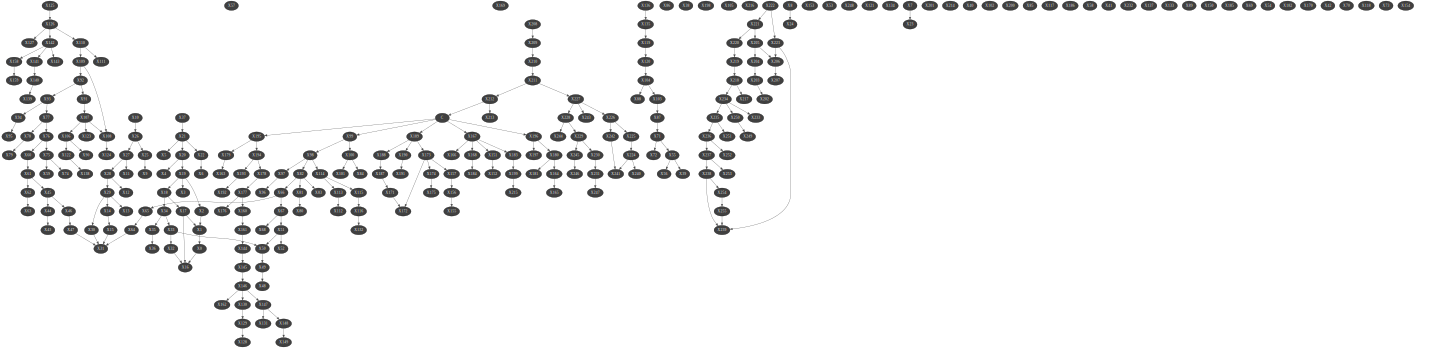

In [4]:
bn=learner.learnBN()

struct= learner.learnDAG()

gnb.showBN(bn, size=20)

In [5]:
print(bn.dag().parents(bn.idFromName("C")))


print (bn.idFromName("C"))

{213}
0


<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 4</h1>

Dans le réseau ci-dessus, observez la variable classe C, qui se trouve vers le haut et au milieu horizontalement   de la figure. Elle a peu de voisins. Or, si on observe tous les pixels d'une image, ce sont seulement ces "voisins" qui sont informatifs. Plus précisément, dans un réseau bayésien, un n&oelig;ud est indépendant de tous les autres n&oelig;uds sachant sa couverture de Markov (<i>Markov blanket</i>). On peut donc supprimer toutes les variables Xi excepté celles de la couverture de Markov sans altérer notre prédiction du chiffre que doit contenir l'image. On rappelle que la couverture de Markov d'un n&oelig;ud C est constitué&nbsp;:

* des parents de C,
* des enfants de C,
* des parents des enfants de C (excepté C lui-même)

Ecrivez une fonction <code>extract_Markov_blanket</code> qui prend en paramètres un réseau bayésien <code>bn</code> ainsi que le nom <code>target_name</code> d'une variable et qui renvoie un couple dont :

* le premier élément est un <b>nouveau</b> bayésien contenant uniquement le n&oelig;ud target et sa couverture de Markov ;
* le deuxième élément est l'ensemble des identifiants des n&oelig;uds de la couverture de Markov.

Idée d'algorithme : on commence par copier le réseau <code>bn</code>. Pour cela, pyAgrum offre un constructeur de copie <code>gum.BayesNet(bn)</code>. On récupère l'identifiant du n&oelig;ud target (<code>bn.idFromName(nom)</code> renvoie l'identifiant d'un n&oelig;ud à partir de son nom). On récupère la structure graphique du réseau via l'expression <code>bn.dag()</code>. A partir de ce DAG, on peut alors calculer les identifiants des n&oelig;uds de la couverture de Markov et supprimer du <i>Bayes net</i> copié tous les n&oelig;uds excepté la classe et sa couverture de Markov (pour supprimer un n&oelig;ud <code>n</code> d'un réseau <code>net</code>, utilisez l'expression <code>net.erase(n)</code>. Cela supprimera le n&oelig;ud de la structure graphique ainsi que sa CPT).

Appliquez votre fonction au réseau appris par le BN learner et affichez le nouveau réseau obtenu

In [6]:
def extract_Markov_blanket(bn, target_name) :
    copy_bn = gum.BayesNet(bn)
    target_id = bn.idFromName(target_name)
    net = copy_bn.dag()
    parent_c=list(net.parents(target_id))
    enfant_c=list(net.children(target_id))
    parent_enfant_c = list()
    for ec in enfant_c:
        parent_enfant_c.append(net.parents(ec))
    for node in net.nodes() :
        if (node not in parent_c) and (node not in enfant_c) and (node not in parent_enfant_c) and node is not target_id :
            net.eraseNode(node)
            print(net.nodes())
    copy_bn.dag = net
    return (copy_bn, net.nodes())

In [7]:
result = extract_Markov_blanket(bn,'C')

{0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 22

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 5</h1>

Recopiez les codes des fonctions suivantes du TP n°2 :

* fonction <code>posterior</code> de la question 10
* fonction <code>classe_max_1_image</code> de la question 9
* fonction <code>classe_max_toutes_images</code> de la question 11

Rajoutez en 2ème argument de ces fonctions un paramètre <code>blanket_nodes</code> qui contiendra les identifiants des n&oelig;uds de la couverture de Markov et mettez à jour vos fonctions de telle sorte que seuls les n&oelig;uds Xi de cette couverture sont observés.

Recalculez la matrice de prédiction, comme vous l'aviez fait dans la question 11 du TP n°2.

In [8]:
# recopie des codes des questions 10, 9, 11
def posterior(inf, image, blanket_nodes):
    """
    Etant donné un algo d'inférence probabiliste inf et une image,
    posterior renvoie la distribution a posteriori de la variable
    classe C sachant l'image. C'est un Potentiel de pyAgrum.
    """
    for pixel in range(NB_PIXELS):
        if pixel in blanket_nodes :
            inf.chgEvidence('X' + str(pixel), image[pixel])
    return inf.posterior('C')


def classe_max_1_image(inf, image, blanket_nodes):
    """
    Etant donné un algo d'inférence probabiliste inf et une image,
    renvoie un couple avec la classe la plus probable, c'est-à-dire
    l'argmax de la distribution a posteriori P(classe C | image).
    """
    proba = posterior(inf, image, blanket_nodes)
    res = proba.argmax()
    return res[0][0]['C'], res[1]



    """
    Etant donné un dataset d'images créé avec la fonction read_file,
    renvoie une matrice carrée 10x10. Chaque ligne de la matrice 
    contient la distribution de probabilité des classes prédites
    sachant la vraie classe
    """
def classe_max_toutes_images(bn,dataset, blanket_nodes):
    inf = gum.LazyPropagation(bn)
    for i in range(NB_PIXELS):
        variable = str('X{0}').format(i)
        inf.addEvidence(variable, 0)
    matrix = np.zeros((10, 10 ))
    for label in range(10):
        for image in dataset[label]:
            prediction = classe_max_1_image(inf,image, blanket_nodes)[0]
            matrix[label][prediction] += 1
        for predictionIndex in range(10):
            matrix[label][predictionIndex] /= len(dataset[label])
    return matrix

prediction_matrix = classe_max_toutes_images(result[0], result[1], test_data)
prediction_matrix

TypeError: 'set' object is not subscriptable

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 6</h1>

Recopiez la fonction <code>accuracy</code> du TP n°2 et calculez l'exactitude de votre matrice de prédiction. Notez qu'avec une dizaine de pixels au lieu des 256, on prédit déjà pas mal de chiffres correctement. 

In [ ]:
def accuracy(matrix, dataset):
    nb_corrects = 0.0
    nb_all = 0.0
    for i in range(10):
        nb_corrects += matrix[i][i] * len(dataset[i])
        nb_all += len(dataset[i])
    rate = nb_corrects / nb_all
    return rate

#accuracy(prediction_matrix, test_data)

<hr style="height: 3px; background-color: #0071b9;">
<h1 style="color: #0071b9;">Question 7</h1>

Le taux de succès de nos prédictions est assez faible. C'est dû au fait que les domaines des variables sont trop gros comparé à la taille de la base de données. Celle-ci ne permet en effet pas aux n&oelig;uds d'avoir beaucoup de parents (les scores diminuant trop rapidement avec le nombre de parents). Reprenez le code de la fonction <code>calcule_accuracy_par_niveau</code> de la dernière section du TP n°2 et adaptez-le pour utiliser, maintenant, vos réseaux avec couvertures de Markov. Exécutez-le avec les mêmes discrétisations <code>[2,3,5,8,12,16]</code> que dans le TP n°2.

In [ ]:
def calcule_accuracy_par_niveau(niveaux_gris):
    """
    Renvoie un dictionnaire {niveau_gris : accuracy}
    """
    global NB_NIVEAUX_GRIS
    
    result = {}
    for nb_niveaux_gris in niveaux_gris:
        print("processing NB_NIVEAUX_GRIS =", nb_niveaux_gris)
        NB_NIVEAUX_GRIS = nb_niveaux_gris

        # relecture et discrétisation des données
        training_data = read_file("datasets/usps_train.txt")
        test_data = read_file("datasets/usps_test.txt")

        # création du naïve Bayes
        bn = create_naive_bayes(training_data, 0.1)

        # calcul de la matrice de prédiction
        prediction_matrix = classe_max_toutes_images(bn, test_data)

        # calcul de l'exactitude
        result[nb_niveaux_gris] = accuracy(prediction_matrix, test_data)
    
    return result

# sensibilite = dictionnaire associant à chaque niveau de gris parmi les
# niveaux de la liste "niveaux_gris" l'exactitude correspondante.
niveaux_gris = [2,3,5,8,12,16]
#sensibilite = calcule_accuracy_par_niveau(niveaux_gris)
#sensibilite

In [ ]:
# on affiche graphiquement l'évolution de l'exactitude en fonction de la
# discrétisation en niveaux de gris
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(niveaux_gris, [sensibilite[niveau] for niveau in sensibilite])
plt.ylim([0,1])
plt.show()